In [11]:
######################################
## running kernel is scvi2, which is scvi-tools conda env
## original code from https://moscot.readthedocs.io/en/latest/notebooks/tutorials/200_temporal_problem.html
######################################
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scvi-tools/bin/python
3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:24) [GCC 13.3.0]
sys.version_info(major=3, minor=10, micro=15, releaselevel='final', serial=0)


In [12]:
import os
import warnings

import moscot as mt

import moscot.plotting as mpl
from moscot.problems.time import TemporalProblem

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scanpy as sc

plt.rcParams["legend.scatterpoints"] = 1
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

In [13]:
mt.__version__, sc.__version__

('0.5.0', '1.10.3')

In [17]:
import h5py

In [23]:
file_path = os.path.join("/groups/tanaka/People/current/jiwang/projects/RA_competence/data/tmps", "adata_for_moscot.h5ad")
adata = sc.read(file_path, chunk_size=6000)

In [24]:
adata

AnnData object with n_obs × n_vars = 22604 × 20242
    obs: 'sample', 'name', 'stage', 'stage_num', 'int_id', 'seq_id_gex_id', 'seq_id_atac', 'reporter', 'experiment_batch', 'sequencing_batch', 'n_counts', 'log_counts', 'n_counts_rank', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'final_doublets', 'final_doublets_cat', 'doublet_calls', 'batch', 'size_factors', 'leiden', 'leiden_05_rna', 'leiden_05_atac', 'leiden_1_rna', 'leiden_1_atac', 'leiden_combined', 'leiden_gex_graph', 'leiden_ATAC_graph', 'leiden_wnn_graph', 'cell_type', 'cell_type_refined', 'S_score', 'G2M_score', 'phase', 'proliferation'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'ambient_genes_E14_5-0', 'is_ambient_E14_5-0', 'n_counts-0', 'n_counts-1', 'ambient_genes_E15_5-1', 'is_ambient_E15_5-1', 'n_counts-2', 'ambient_genes_NVF_E15-5_Rep2-2', 'is_ambient_NVF_E15-5_Rep2-2', 'n_counts-3', 'ambient_genes_NVF_E16-5_Rep1-3', 'is_ambient_NVF_E16-5_Rep1-3', 'is_ambient', 'n_counts', 'n_cells', 'hig

In [33]:
adata.mod['rna']

AttributeError: 'AnnData' object has no attribute 'mod'

In [25]:
#adata = mt.datasets.pancreas_multiome(rna_only=True, force_download=True)
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Ngn3 high cycling",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon",
]

adata = adata[adata.obs["cell_type"].isin(endocrine_celltypes)].copy()

In [26]:
def adapt_time(x):
    if x["stage"] == "E14.5":
        return 14.5
    if x["stage"] == "E15.5":
        return 15.5
    if x["stage"] == "E16.5":
        return 16.5
    raise ValueError


adata.obs["time"] = adata.obs.apply(adapt_time, axis=1).astype("category")

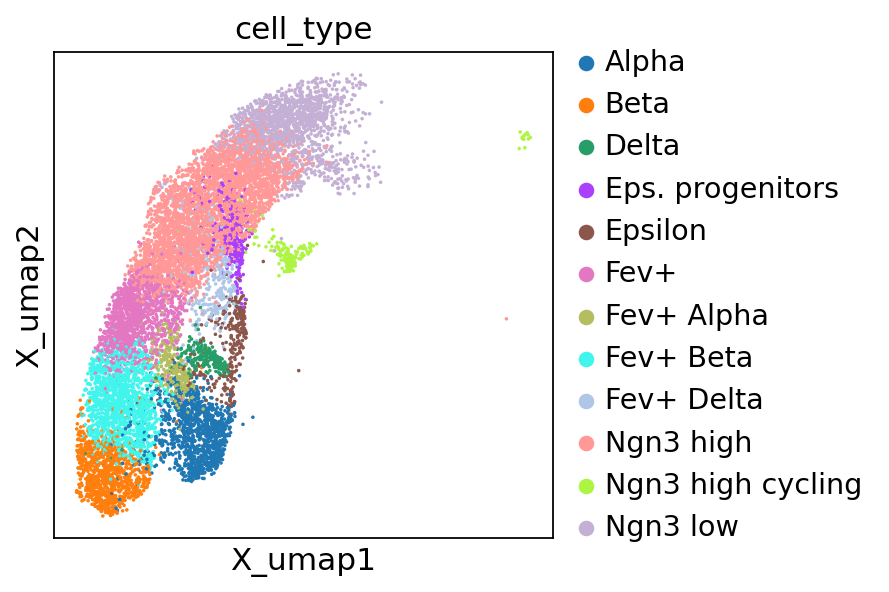

In [27]:
sc.pl.embedding(adata, basis="X_umap", color="cell_type")

In [35]:
tp0 = TemporalProblem(adata)

In [36]:
tp0 = tp0.prepare(time_key="time", joint_attr="X_MultiVI")

In [37]:
import networkx as nx

dfs = {}
batch_column = "time"
unique_batches = [14.5, 15.5, 16.5]
for i in range(len(unique_batches) - 1):
    batch1 = unique_batches[i]
    batch2 = unique_batches[i + 1]

    indices = np.where(
        (adata.obs[batch_column] == batch1) | (adata.obs[batch_column] == batch2)
    )[0]
    adata_subset = adata[indices]
    sc.pp.neighbors(adata_subset, use_rep="X_MultiVI", n_neighbors=30)
    G = nx.from_numpy_array(adata_subset.obsp["connectivities"].todense())
    assert nx.is_connected(G)

    dfs[(batch1, batch2)] = pd.DataFrame(
        index=adata_subset.obs_names,
        columns=adata_subset.obs_names,
        data=adata_subset.obsp["connectivities"].todense().astype("float"),
    )

In [38]:
tp0[14.5, 15.5].set_graph_xy((dfs[14.5, 15.5]).astype("float"), t=100.0)
tp0[15.5, 16.5].set_graph_xy((dfs[15.5, 16.5]).astype("float"), t=100.0)

In [ ]:
tp0 = tp0.solve(epsilon=1e-3, scale_cost="mean", max_iterations=1e7)

INFO     Solving `2` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5185, 1699)].                                  


In [ ]:
tp0.save("tp.pt")

In [ ]:
order_celltypes = [
    "Ngn3 low",
    "Ngn3 high cycling",
    "Ngn3 high",
    "Eps. progenitors",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon",
]

ct_desc = tp0.cell_transition(
    14.5,
    15.5,
    {"cell_type": order_celltypes},
    {"cell_type": order_celltypes},
    forward=False,
    key_added="transitions_14.5_15.5_large",
)
ct_desc = tp0.cell_transition(
    15.5,
    16.5,
    {"cell_type": order_celltypes},
    {"cell_type": order_celltypes},
    forward=False,
    key_added="transitions_15.5_16.5_large",
)

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

axes[0] = mpl.cell_transition(
    tp0,
    fontsize=7,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[0],
    key="transitions_14.5_15.5_large",
)

axes[1] = mpl.cell_transition(
    tp0,
    fontsize=7,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[1],
    key="transitions_15.5_16.5_large",
)


fig.subplots_adjust(wspace=0.8)

In [ ]:
ct_desc = tp0.cell_transition(
    14.5,
    15.5,
    {"cell_type": order_celltypes},
    {"cell_type": order_celltypes},
    forward=True,
    key_added="transitions_14.5_15.5",
)
ct_desc = tp0.cell_transition(
    15.5,
    16.5,
    {"cell_type": order_celltypes},
    {"cell_type": order_celltypes},
    forward=True,
    key_added="transitions_15.5_16.5",
)

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

axes[0] = mpl.cell_transition(
    tp0,
    fontsize=7,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[0],
    key="transitions_14.5_15.5",
)

axes[1] = mpl.cell_transition(
    tp0,
    fontsize=7,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[1],
    key="transitions_15.5_16.5",
)


fig.subplots_adjust(wspace=0.8)

In [ ]:
cluster_subset = [
    "Eps. progenitors",
    "Fev+ Delta,0",
    "Fev+ Delta,1",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon",
]

tp0.sankey(
    source=14.5,
    target=16.5,
    source_groups={"cell_type_refined": cluster_subset},
    target_groups={"cell_type_refined": cluster_subset},
    threshold=0.05,
    order_annotations=cluster_subset[::-1],
    normalize=True,
)

In [ ]:
color_dict = {
    "Prlf. Ductal": "#f7b6d2",
    "Ductal": "#d62728",
    "Imm. Acinar": "#ffeb3b",
    "Mat. Acinar": "#98df8a",
    "Alpha": "#1f77b4",
    "Beta": "#ff7f0e",
    "Delta": "#279e68",
    "Eps. progenitors": "#aa40fc",
    "Epsilon": "#8c564b",
    "Fev+": "#e377c2",
    "Fev+ Alpha": "#b5bd61",
    "Fev+ Beta": "#42f5ec",
    "Fev+ Delta": "#aec7e8",
    "Fev+ Delta,0": "#17becf",
    "Fev+ Delta,1": "#98df8a",
    "Ngn3 high cycling": "#adf542",
    "Ngn3 high,0": "#ff9896",
    "Ngn3 high": "#ff9896",
    "Ngn3 high,1": "#f0b98d",
    "Ngn3 low": "#c5b0d5",
}
tp0.adata.uns["cell_type_refined_colors"] = [
    color_dict[ct] for ct in tp0.adata.obs["cell_type_refined"].cat.categories
]

In [ ]:
mpl.sankey(tp0, dpi=100, figsize=(12, 4), fontsize=10, interpolate_color=True)